In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from dask.distributed import Client

client = Client(n_workers=32, threads_per_worker=1)
client

/home/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43023 instead
  http_address["port"], self.http_server.port


In [ ]:
epoch_key = 'bon', 8, 4

In [ ]:
from src.load_data import load_data
from src.parameters import _MARKS

import logging

logging.basicConfig(level='INFO', format='%(asctime)s %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

animal, day, epoch = epoch_key
data_type, dim = 'clusterless', '1D'

logging.info('Loading data...')
data = load_data(epoch_key)
data['multiunit'] = data['multiunit'].sel(features=_MARKS)

In [ ]:
from loren_frank_data_processing.position import (EDGE_ORDER, EDGE_SPACING,
                                                  make_track_graph)
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY,
                            continuous_transition_types, discrete_diag,
                            knot_spacing, model, model_kwargs, movement_var,
                            place_bin_size, replay_speed, spike_model_penalty)

position = data['position_info'].loc[:, 'linear_position']
track_graph, center_well_id = make_track_graph(epoch_key, ANIMALS)

In [34]:
place_bin_size

3.0

In [ ]:
from replay_trajectory_classification import ClusterlessClassifier
import xarray as xr
import numpy as np

from trajectory_analysis_tools import get_distance_metrics, get_trajectory_data
import pandas as pd
from sklearn.model_selection import KFold


cv = KFold()
results = []
index = pd.Index([f"{animal}_{day:02d}_{epoch:02d}"])
error_info = pd.DataFrame([], index=index)


for fold_ind, (train, test) in enumerate(cv.split(data["position_info"].index)):
    logging.info(f'Fitting Fold #{fold_ind + 1}...')
    classifier = ClusterlessClassifier(
        place_bin_size=place_bin_size,
        movement_var=movement_var,
        replay_speed=replay_speed,
        discrete_transition_diag=discrete_diag,
        continuous_transition_types=continuous_transition_types,
        model=model,
        model_kwargs=model_kwargs)
    classifier.fit(
        position=data["position_info"].iloc[train].linear_position,
        multiunits=data["multiunit"].isel(time=train),
        track_graph=track_graph,
        center_well_id=center_well_id,
        edge_order=EDGE_ORDER,
        edge_spacing=EDGE_SPACING,
    )

    logging.info('Predicting posterior...')
    results.append(
        classifier.predict(
            data["multiunit"].isel(time=test),
            time=data["position_info"].iloc[test].index,
        )
    )
    
    posterior = results[fold_ind].acausal_posterior.sum('state')

    (actual_projected_position, actual_edges, head_directions,
     map_position_2d, map_edges) = get_trajectory_data(
        posterior, track_graph, classifier, data['position_info'].iloc[test])

    distance_metrics = get_distance_metrics(track_graph, actual_projected_position, actual_edges,
                                            head_directions, map_position_2d, map_edges)
    
    is_running = np.asarray(data["position_info"].iloc[test].speed > 4)

    error_info[f"median_error_fold_{fold_ind + 1}"] = np.median(
        distance_metrics.mental_position_distance_from_animal)
    error_info[f"run_median_error_fold_{fold_ind + 1}"] = np.median(
        distance_metrics.mental_position_distance_from_animal[is_running])
    

results = (xr.concat(results, dim="time")
           .assign_coords(state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))
error_info['animal'] = animal
error_info['day'] = int(day)
error_info['epoch'] = int(epoch)

In [14]:
error_info

,median_error_fold_1,run_median_error_fold_1,median_error_fold_2,run_median_error_fold_2,median_error_fold_3,run_median_error_fold_3,median_error_fold_4,run_median_error_fold_4,median_error_fold_5,run_median_error_fold_5,animal,day,epoch
bon_08_04,1.455324,7.100026,5.139973,8.073631,1.455324,5.875751,1.455324,6.408488,1.455324,5.920144,bon,8,4


In [15]:
results

<xarray.Dataset>
Dimensions:            (position: 98, state: 3, time: 461997)
Coordinates:
  * time               (time) timedelta64[ns] 01:00:46.016600 ... 01:16:10.00...
  * position           (position) float64 1.448 4.344 7.24 ... 298.2 301.2 304.1
  * state              (state) object 'Continuous' 'Fragmented' 'Hover'
Data variables:
    likelihood         (time, state, position) float64 1.0 0.9878 ... 0.936
    causal_posterior   (time, state, position) float64 0.005196 ... 0.0002527
    acausal_posterior  (time, state, position) float64 0.003752 ... 0.0002527

In [ ]:
import os

epoch_identifier = f'{animal}_{day:02d}_{epoch:02d}_{data_type}_{dim}'
prob = int(PROBABILITY_THRESHOLD * 100)
error_info_filename = os.path.join(
    PROCESSED_DATA_DIR, f'{epoch_identifier}_error_info_{prob:02d}.csv')
error_info.to_csv(error_info_filename)

In [ ]:
import copy
import matplotlib.pyplot as plt
import seaborn as sns

from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS, PROBABILITY_THRESHOLD
from src.analysis import get_probability, get_is_classified



def plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(30, 15),
):

    t = data["position_info"].index / np.timedelta64(1, "s")
    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)
    

    fig, axes = plt.subplots(
        5,
        1,
        figsize=figsize,
        sharex=True,
        constrained_layout=True,
        gridspec_kw={"height_ratios": [1, 4, 1, 1, 1]},
    )
    
    # ax 0
    probability = (results[posterior_type]
     .sel(time=time_slice)
     .sum("position")
     .assign_coords(
        time=lambda ds: ds.time / np.timedelta64(1, 's'),
     ))
    for state, prob in zip(probability.state.values, probability.values.T):
        axes[0].plot(
            probability.time,
            prob,
            linewidth=1,
            color=STATE_COLORS[state],
            clip_on=False,
            label=state,
        )
    axes[0].set_ylabel("Probability")
    axes[0].set_xlabel("")
    axes[0].set_ylim((0, 1))
    axes[0].set_yticks((0, 1))
    
    is_classified = get_is_classified(
        get_probability(results.sel(time=time_slice)),
        PROBABILITY_THRESHOLD)

    for state, is_class in zip(is_classified.state.values,
                               is_classified.values.T):
        if is_class.sum() > 0:
            axes[0].fill_between(
                probability.time,
                is_class,
                where=is_class.astype(bool),
                alpha=0.25,
                color=STATE_COLORS[state],
            )

    # ax 1
    (results[posterior_type]
     .sel(time=time_slice)
     .sum('state')
     .where(classifier.is_track_interior_)
     .assign_coords(
        time=lambda ds: ds.time /
        np.timedelta64(1, 's'))
     .plot(
         x="time", y="position",
         robust=True,
         ax=axes[1],
         cmap=cmap,
         vmin=0.0,
         add_colorbar=False,
    ))

    axes[1].scatter(
        data["position_info"].loc[time_slice].index / np.timedelta64(1, 's'),
        data["position_info"]
        .loc[time_slice]
        .linear_position,
        color="magenta",
        alpha=0.8,
        s=1,
    )
    axes[1].set_xlabel("")
    max_position = np.ceil(
        np.asarray(data['position_info'].linear_position).max()).astype(int)
    axes[1].set_ylim((0, max_position))
    axes[1].set_yticks((0, max_position))
    axes[1].set_ylabel("Position [cm]")
    
    # ax 2

    axes[2].fill_between(
        data["multiunit_firing_rate"].loc[time_slice].index / np.timedelta64(1, 's'),
        data["multiunit_firing_rate"].loc[time_slice].squeeze(),
        color="black",
    )
    axes[2].set_ylabel("Multiunit\nFiring Rate\n[spikes / s]")
    axes[2].set_ylim((0, 150))
    axes[2].set_yticks((0, 50, 100, 150))
    
    # ax 2

    axes[3].fill_between(
        data["ripple_consensus_trace_zscore"].loc[time_slice].index / np.timedelta64(1, 's'),
        data["ripple_consensus_trace_zscore"].loc[time_slice].squeeze(),
        color="black",
    )
    axes[3].set_ylabel("Ripple\nConsensus\nZ-score")
    is_ripple = ((data['ripple_times'].start_time > time_slice[0].values) &
                 (data['ripple_times'].end_time < time_slice[-1].values))
    for ripple in data['ripple_times'].loc[is_ripple].itertuples():
        zscore = data["ripple_consensus_trace_zscore"].loc[ripple.start_time:ripple.end_time]
        axes[3].scatter(zscore.ripple_consensus_trace_zscore.idxmax() / np.timedelta64(1, 's'),
                        zscore.max(), zorder=100, marker='*', color='red')
    
    # ax 4
    axes[4].fill_between(
        data["position_info"].loc[time_slice].index / np.timedelta64(1, 's'),
        data["position_info"]
               .loc[time_slice]
               .speed.values.squeeze(),
        color="lightgrey",
        linewidth=1,
        alpha=0.7,
    )
    axes[4].set_ylim((0, 50))
    axes[4].set_yticks((0, 50))
    axes[4].set_ylabel("Speed\n[cm / s]")
    axes[4].set_xlabel("Time [s]")
    sns.despine(offset=5)

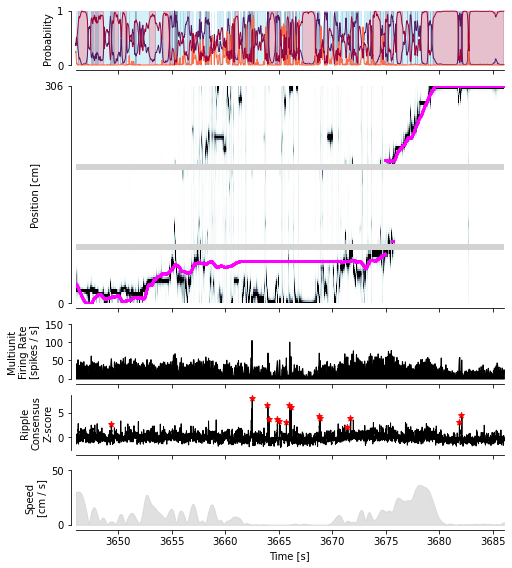

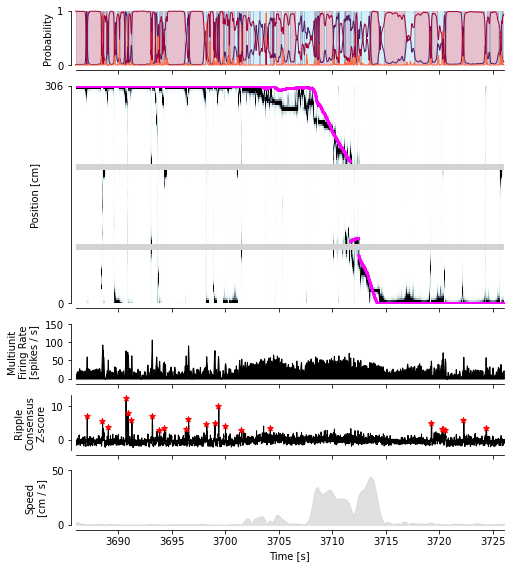

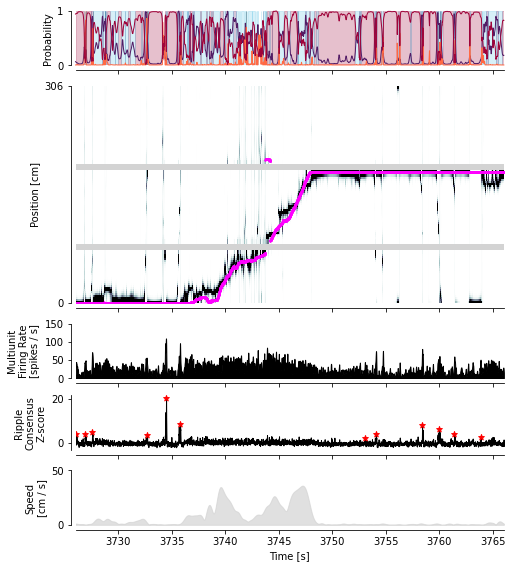

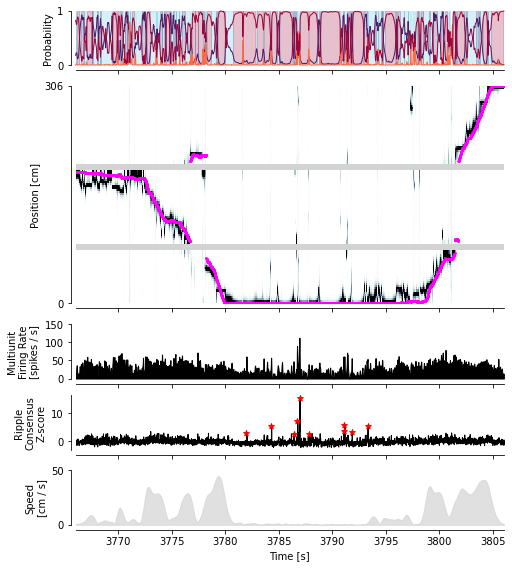

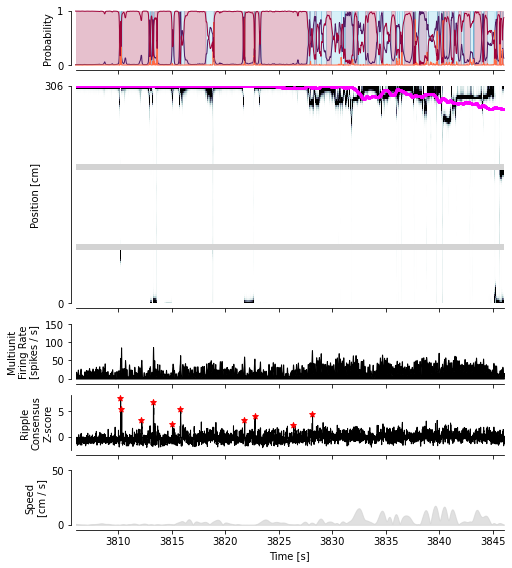

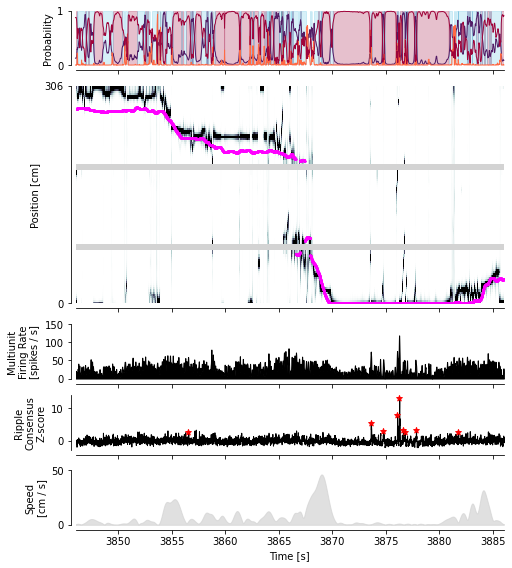

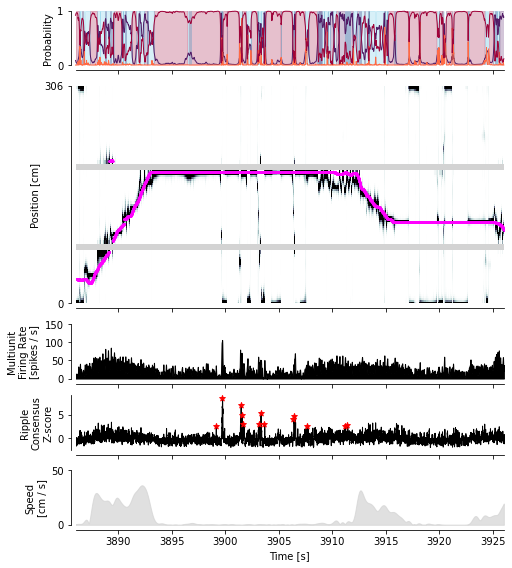

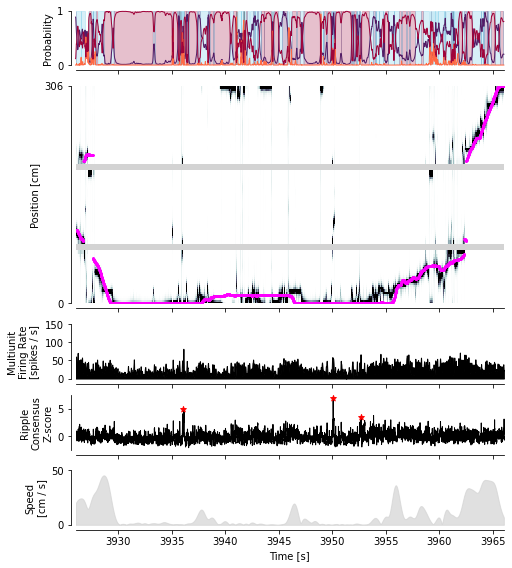

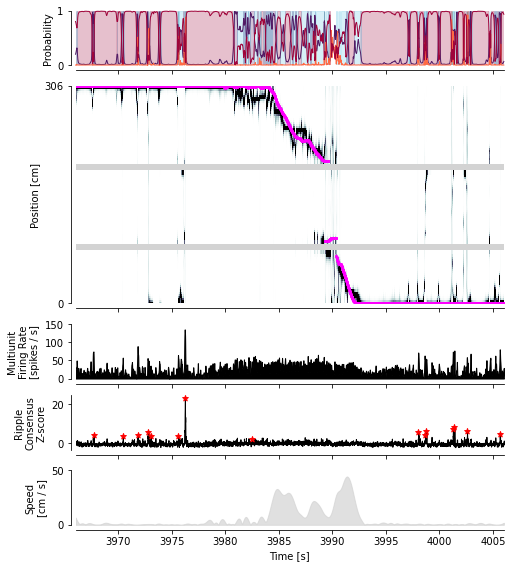

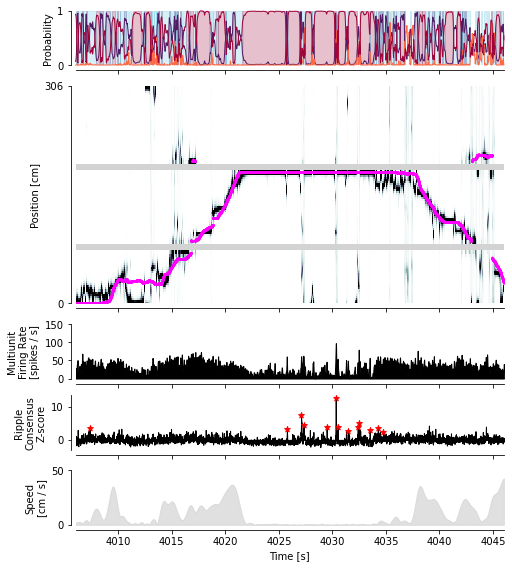

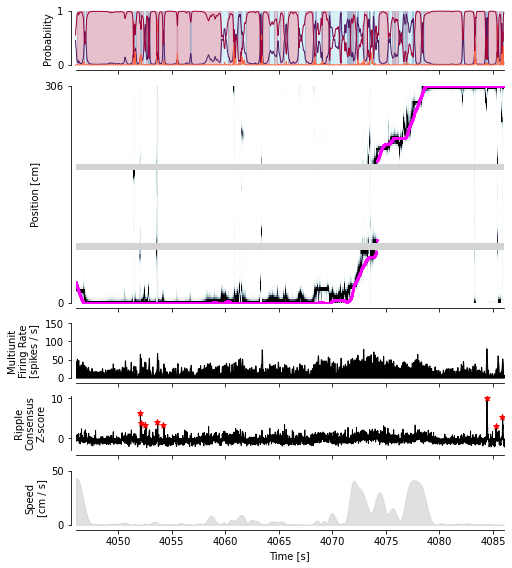

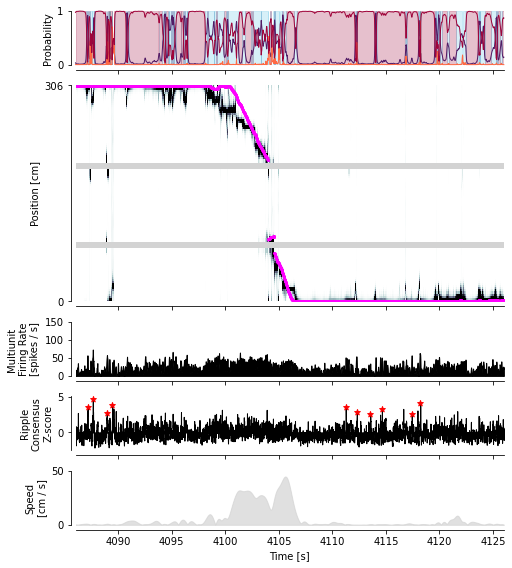

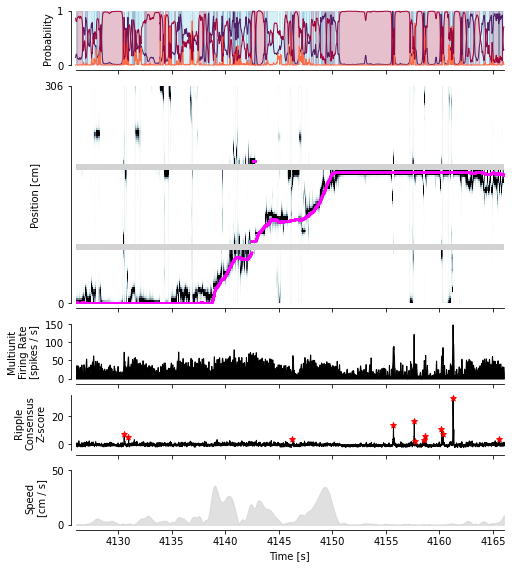

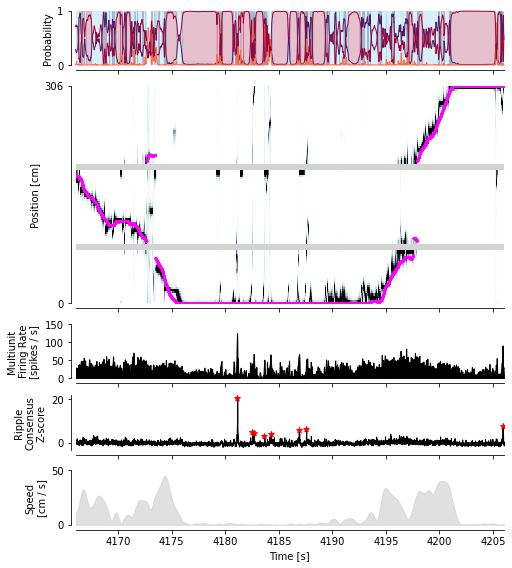

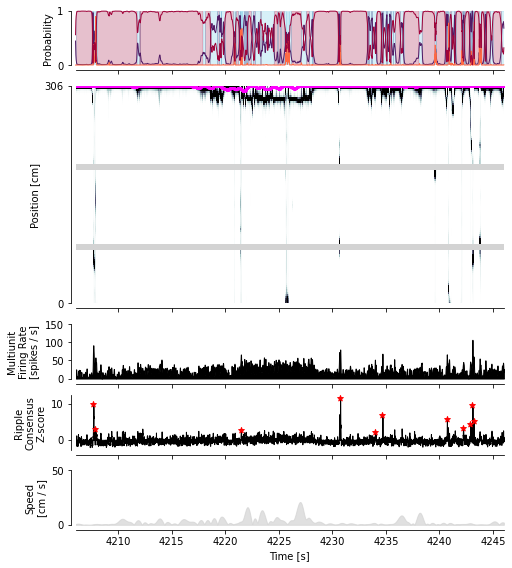

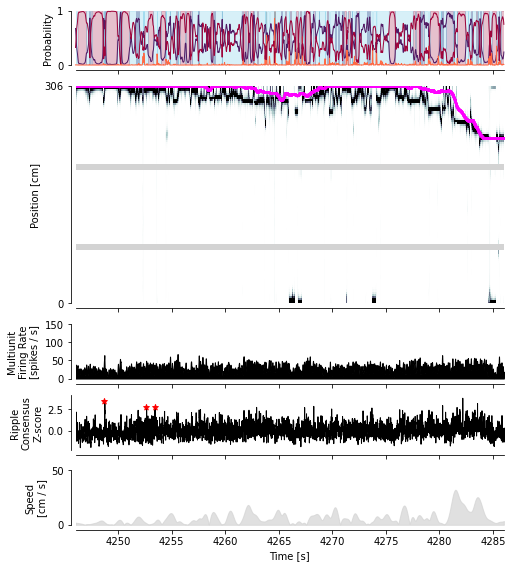

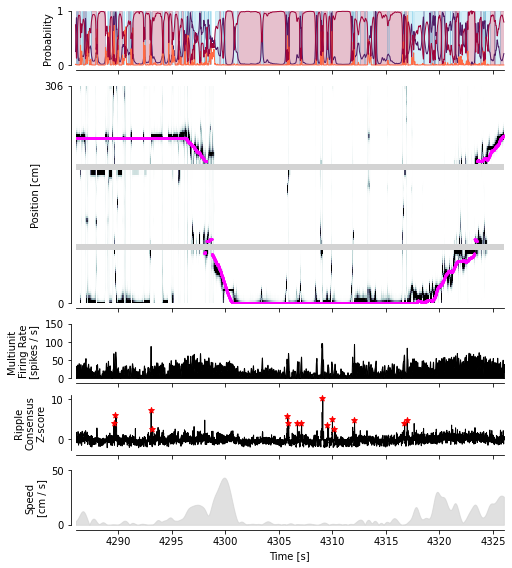

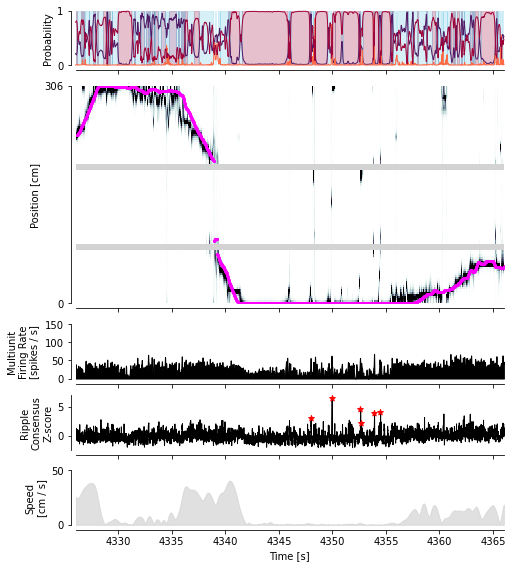

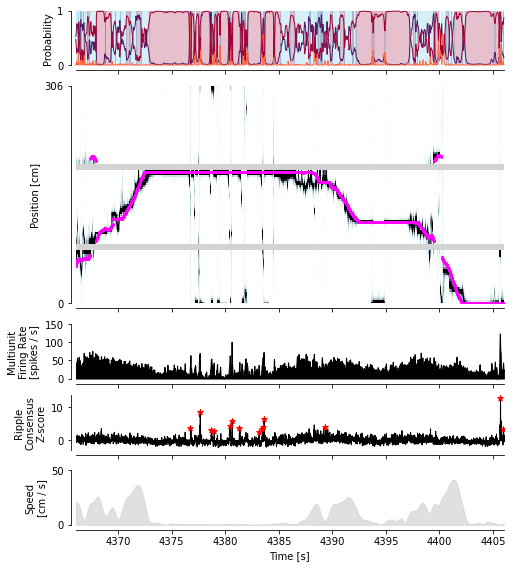

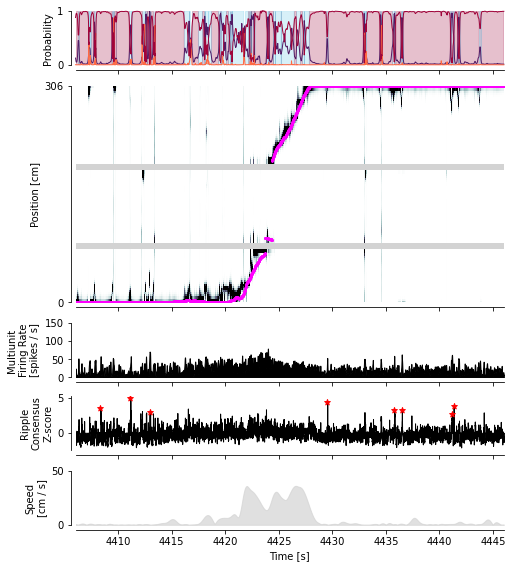

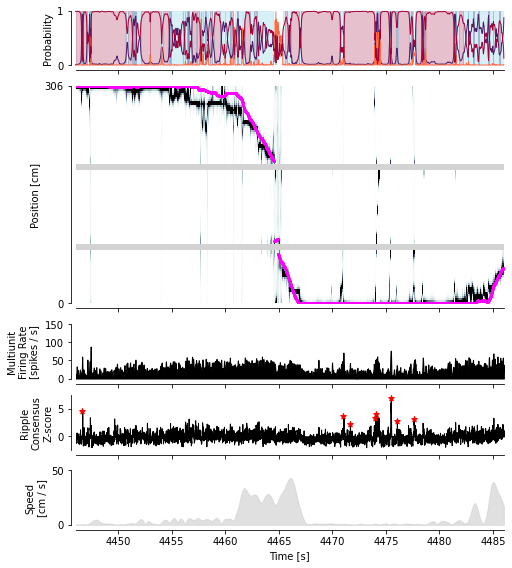

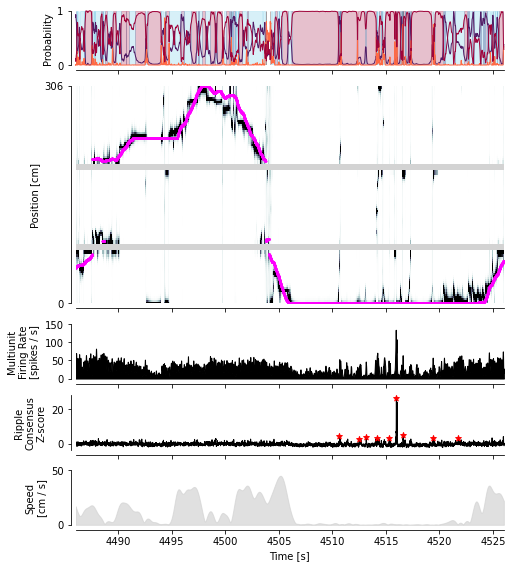

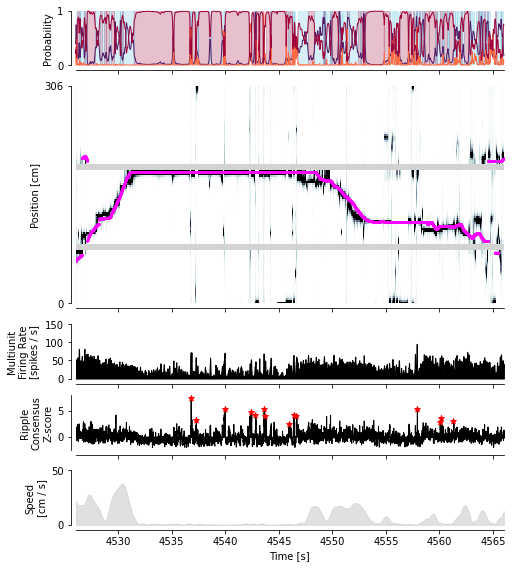

In [16]:
    from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT

time_ind = list(range(0, len(results.time), 20_000))

for start_ind, end_ind in zip(time_ind[:-1], time_ind[1:]):
    time_slice = results.time[slice(start_ind, end_ind)]

    plot_classifier_time_slice(
        time_slice,
        classifier,
        results,
        data,
        posterior_type="acausal_posterior",
        figsize=(TWO_COLUMN, PAGE_HEIGHT * 0.8),
    )

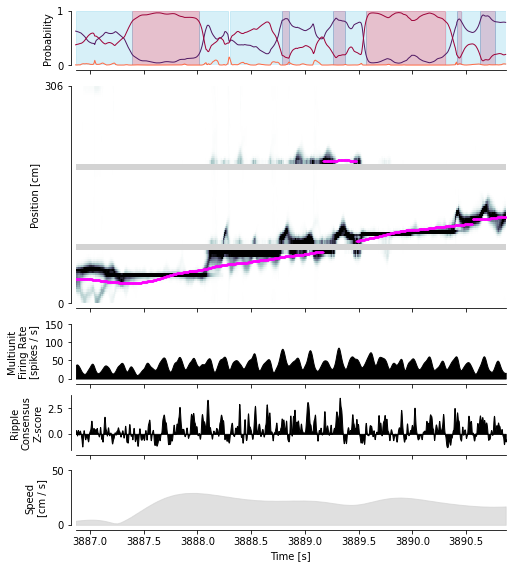

In [29]:
time_slice = results.sel(time=slice(results.time.min() + pd.Timedelta(240.85, unit='s'),
                                    results.time.min() + pd.Timedelta(244.85, unit='s'))).time

plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(TWO_COLUMN, PAGE_HEIGHT * 0.8),
)

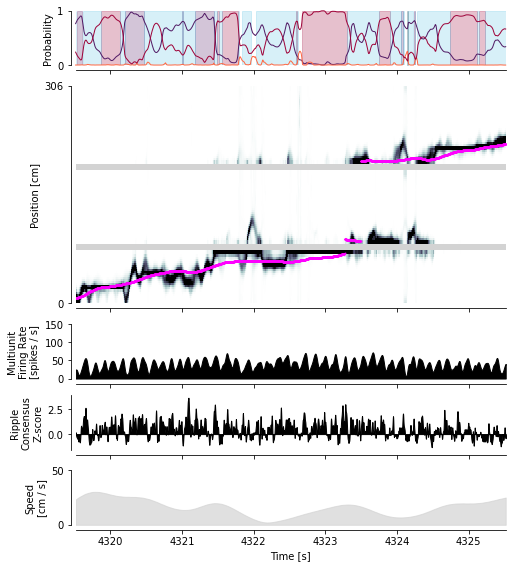

In [30]:
time_slice = results.sel(time=slice(results.time.min() + pd.Timedelta(673.5, unit='s'),
                                    results.time.min() + pd.Timedelta(679.5, unit='s'))).time

plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(TWO_COLUMN, PAGE_HEIGHT * 0.8),
)

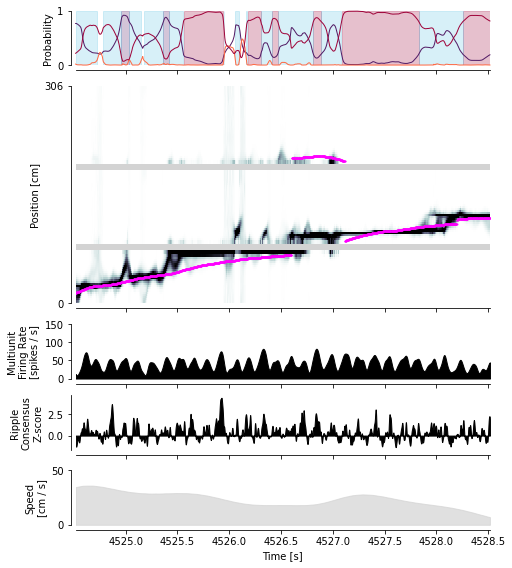

In [31]:
time_slice = results.sel(time=slice(results.time.min() + pd.Timedelta(878.5, unit='s'),
                                    results.time.min() + pd.Timedelta(882.5, unit='s'))).time

plot_classifier_time_slice(
    time_slice,
    classifier,
    results,
    data,
    posterior_type="acausal_posterior",
    figsize=(TWO_COLUMN, PAGE_HEIGHT * 0.8),
)

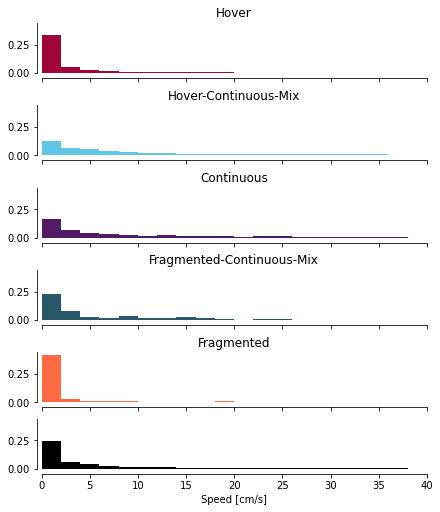

In [32]:
from src.parameters import STATE_ORDER

is_classified = get_is_classified(
    get_probability(results),
    PROBABILITY_THRESHOLD)

speed = np.asarray(data['position_info'].speed).squeeze()
n_states = len(is_classified.state)

fig, axes = plt.subplots(n_states + 1, 1, constrained_layout=True, sharex=True, sharey=True, figsize=(6, 7))

for ax, state in zip(axes.flat, STATE_ORDER):
    ax.hist(speed[is_classified.sel(state=state).values.astype(bool)],
            color=STATE_COLORS[state],
            bins=np.arange(0, 40, 2),
            density=True)
    ax.set_title(state)

axes[-1].hist(speed, bins=np.arange(0, 40, 2), density=True, color='black')
axes[-1].set_xlabel("Speed [cm/s]")
axes[-1].set_xlim((0, 40))

sns.despine(offset=5)


In [ ]:
client.close()